In [1]:
# Read in data

import pandas as pd

url = 'SentenceQualitySlim.csv'

data = pd.read_csv(url, encoding='utf-8')

# drop na rows
data = data.dropna(how='all')

# convert sentences column to string
data['Sentences'] = data['Sentences'].astype(str)

data

,Entry,Year,Endorsements,Internal,Count,Sentences,External
0,1.0,2000.0,948.0,0.89,8.0,Sleep induction (time it takes you to fall asl...,2.410
1,2.0,2013.0,522.0,0.85,5.0,It is exciting to figure out new ways to solve...,7.590
2,3.0,2013.0,522.0,0.72,4.0,Establishing a new company excites me.; Owning...,7.590
3,4.0,2013.0,522.0,0.77,4.0,I really like finding the right people to mark...,7.590
4,5.0,1996.0,2227.0,0.93,6.0,"If I should find myself in a jam, I could thin...",5.910
...,...,...,...,...,...,...,...
245,246.0,2016.0,92.0,0.81,3.0,Watching Facebook posts is good for overcoming...,2.311
246,247.0,2016.0,92.0,0.72,3.0,I spent time on Facebook at the expense of my ...,2.311
247,248.0,2016.0,92.0,0.80,3.0,My Facebook profile is rather detailed.;I like...,2.311
248,249.0,2011.0,453.0,0.86,4.0,Arrange a study group or meeting;Collaborate o...,3.459


In [2]:
# Clean the text

import spacy
from spacy.tokenizer import Tokenizer
from spacy.lang.en import English
import re

nlp = English()
tokenizer = nlp.tokenizer

def clean_text(text_):
  
  # remove semicolons
  text_ = re.sub(r';', ' ', text_)
  
  # tokenize
  doc = tokenizer(text_)

  # remove punctuation and whitespaces
  tokens = [i.text.lower() for i in doc if not (i.is_punct or i.is_space)]

  return tokens

In [3]:
# create clean text column
data['clean_text'] = data.Sentences.apply(lambda x: clean_text(x))

max_len_row = max(data.clean_text.apply(len))
print('Maximum length row: ',max_len_row)

Maximum length row:  324


In [4]:
# create a word2index array

from collections import Counter

all_tokens = data.clean_text.values.tolist()
all_tokens = [word for sublist in all_tokens for word in sublist]

counter = Counter(all_tokens)
word2index = list(counter.keys())
print('vocabulary size without PAD: ', len(word2index))

word2index.insert(0, 'PAD')
print('Vovabulary size including PAD: ', len(word2index))

vocabulary size without PAD:  2555
Vovabulary size including PAD:  2556


In [5]:
# Import word vectors
import gensim.downloader as api

wv = api.load('glove-wiki-gigaword-50')

In [6]:
import numpy as np

# Make list of integer values for each row
data['integer_values'] = data.clean_text.apply(lambda tokens: [word2index.index(token) for token in tokens])

# Make list of Vector values for each row
data['vector_values'] = data.clean_text.apply(lambda tokens: [wv[token] if (token in wv) else np.random.uniform(-.1,.1, 50) for token in tokens])

# count how many vectors OOV
rand_vecs = [i for i in word2index if not (i in wv)]
print('Num words OOV: ', len(rand_vecs)-1) # excludes PAD
print(rand_vecs[:5])

Num words OOV:  28
['PAD', 'inorning', 'exercrse', 'morethan', 'indeciding']


In [7]:
# Make Matrix of Values

import tensorflow
from tensorflow.keras.preprocessing.sequence import pad_sequences

# index value matrix
sequences_indices = data.integer_values.values.tolist()
matrix_indices = pad_sequences(sequences=sequences_indices, padding = 'post')
print('Shape of index value matrix: ',matrix_indices.shape)

# Vector Matrix
sequences_vecs = data.vector_values.values.tolist()
matrix_vecs = pad_sequences(sequences=sequences_vecs, padding='post')
print('Shape of Vector value matrix: ', matrix_vecs.shape)

Shape of index value matrix:  (250, 324)
Shape of Vector value matrix:  (250, 324, 50)


In [8]:
# Create an embedding matrix of shape (vocab_length+1, vector length)

embedding_matrix = np.zeros((len(word2index), 50))

for i, word in enumerate(word2index):
    if word in wv:
        embedding_matrix[i] = wv[word]
    else:
        embedding_matrix[i] = np.random.uniform(-.1,.1, 50)

embedding_matrix.shape

(2556, 50)

In [9]:
# Data split

import sklearn
from sklearn.model_selection import train_test_split

def split_data(x_input, y_input):
    # Split Indexing Data
    x_train,  x_test,  y_train,  y_test  = train_test_split(x_input, 
                                                            data[[y_input]].values, 
                                                            test_size=.2, 
                                                            random_state=0
                                                            )
    return x_train, x_test, y_train, y_test

# Predict Endorsements

In [10]:
# Plot Endorsement ditribution

print(data.Endorsements.describe())

data.Endorsements.plot.hist()

count      250.000000
mean       645.768000
std       1704.310286
min          1.000000
25%         64.250000
50%        139.000000
75%        380.500000
max      15461.000000
Name: Endorsements, dtype: float64


In [11]:
# build model

import tensorflow as tf
from keras import layers
from keras.models import Sequential
from keras.layers import Dense, Activation, Embedding, LSTM, GRU, SimpleRNN

model = Sequential()

# Add an embedding layer
model.add(
    Embedding(
        input_dim=len(word2index),  # Integer. Size of the vocabulary in the text data
        output_dim=50,              # Integer. Dimension of the dense embedding.
        input_length=max_len_row,   # Length of input sequences, when it is constant. 
        weights = [embedding_matrix],
        trainable=True
    )
)

# Add a Simple RNN Layer
model.add(SimpleRNN(
    128,                    # Positive integer, dimensionality of the output space.
    return_sequences=False  # Boolean. Whether to return the last output in the output sequence, or the full sequence.
))

# Add a Dense Layer
model.add(Dense(
    1,                       # Positive integer, dimensionality of the output space.
    activation="relu"        # Activation function to use. If you don't specify anything, no activation is applied
))


model.compile(loss='mse',           # Loss function. Maybe be a string (name of loss function), or a tf.keras.losses.Loss instance.
              optimizer='adam',     # String (name of optimizer) or optimizer instance.
              metrics=['mse'])      # List of metrics to be evaluated by the model during training and testing. 
model.summary()

Using TensorFlow backend.


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 324, 50)           127800    
_________________________________________________________________
simple_rnn_1 (SimpleRNN)     (None, 128)               22912     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 129       
Total params: 150,841
Trainable params: 150,841
Non-trainable params: 0
_________________________________________________________________


In [12]:
# Split data on Endorsements
x_train, x_test, y_train, y_test = split_data(matrix_indices, 'Endorsements')

print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)


(200, 324)
(50, 324)
(200, 1)
(50, 1)


In [13]:
# Fit Model to Endorsements predictions

simple = model.fit(
    x_train, 
    y_train, # Endorsements
    batch_size=8, 
    epochs=20,
    validation_data=(
        x_test, 
        y_test # Endorsements
    )
)

C:\Users\olive\anaconda3\envs\nlp_tf\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:433: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 200 samples, validate on 50 samples
Epoch 1/20
200/200 [==============================] - 6s 29ms/step - loss: 3615286.7664 - mse: 3615287.0000 - val_loss: 2052180.1603 - val_mse: 2052180.0000
Epoch 2/20
200/200 [==============================] - 5s 24ms/step - loss: 3608221.4082 - mse: 3608221.0000 - val_loss: 2047617.5994 - val_mse: 2047617.7500
Epoch 3/20
200/200 [==============================] - 5s 23ms/step - loss: 3604963.9889 - mse: 3604964.2500 - val_loss: 2044584.2292 - val_mse: 2044584.1250
Epoch 4/20
200/200 [==============================] - 5s 24ms/step - loss: 3602383.8627 - mse: 3602383.2500 - val_loss: 2041978.2347 - val_mse: 2041978.2500
Epoch 5/20
200/200 [==============================] - 5s 24ms/step - loss: 3596001.9190 - mse: 3596001.5000 - val_loss: 2039109.7712 - val_mse: 2039109.7500
Epoch 6/20
200/200 [==============================] - 5s 23ms/step - loss: 3592955.7026 - mse: 3592956.5000 - val_loss: 2036657.4781 - val_mse: 2036657.2500
Epoch 7/20
20

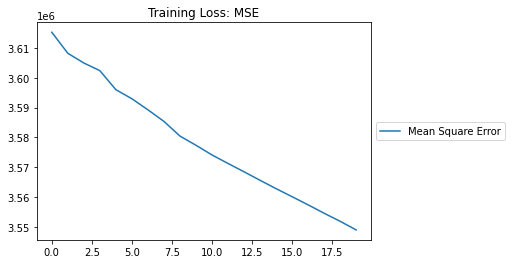

In [14]:
# Plot performance

from matplotlib import pyplot as plt

x = range(20)
plt.plot(x, simple.history['mse'], label="Mean Square Error")

plt.title("Training Loss: MSE")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

#plt.plot(x, simple.history['mae'], label="Mean Absolute Error")
#plt.title("Training Loss: MAE")
#plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
#plt.show()

# Predict Internal

count    250.000000
mean       0.814530
std        0.094576
min        0.460000
25%        0.760000
50%        0.830000
75%        0.880000
max        0.980000
Name: Internal, dtype: float64


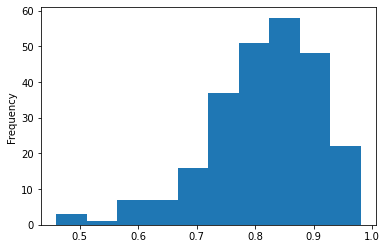

In [15]:
# Plot Internal Distribution

print(data.Internal.describe())

data.Internal.plot.hist()

In [16]:
# split data on internal

x_train, x_test, y_train, y_test = split_data(matrix_indices, 'Internal')

print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(200, 324)
(50, 324)
(200, 1)
(50, 1)


In [27]:
# Build Model for Internal

model_internal = Sequential()

model_internal.add(
    Embedding(
        input_dim = len(word2index),
        output_dim = 50,
        input_length = max_len_row,
        weights = [embedding_matrix],
        
    )
)

# Add a Simple RNN Layer
model_internal.add(SimpleRNN(
    300,                    # Positive integer, dimensionality of the output space.
    return_sequences=True  # Boolean. Whether to return the last output in the output sequence, or the full sequence.
))

# Add a Dense Layer
model_internal.add(Dense(
    1,                       # Positive integer, dimensionality of the output space.
    activation="relu"        # Activation function to use. If you don't specify anything, no activation is applied
))


model_internal.compile(loss='mae',           # Loss function. Maybe be a string (name of loss function), or a tf.keras.losses.Loss instance.
              optimizer='adam',     # String (name of optimizer) or optimizer instance.
              metrics=['mse', 'mae'])      # List of metrics to be evaluated by the model during training and testing. 
model_internal.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_8 (Embedding)      (None, 324, 50)           127800    
_________________________________________________________________
simple_rnn_7 (SimpleRNN)     (None, 324, 300)          105300    
_________________________________________________________________
dense_7 (Dense)              (None, 324, 1)            301       
Total params: 233,401
Trainable params: 233,401
Non-trainable params: 0
_________________________________________________________________


In [28]:
# Split data on Internal
x_train, x_test, y_train, y_test = split_data(matrix_indices, 'Internal')

print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)


(200, 324)
(50, 324)
(200, 1)
(50, 1)


In [29]:
# Fit Model to Endorsements predictions

simple = model.fit(
    x_train, 
    y_train, # Internal
    batch_size=8, 
    epochs=20,
    validation_data=(
        x_test, 
        y_test # Internal
    )
)

Train on 200 samples, validate on 50 samples
Epoch 1/20
200/200 [==============================] - 5s 24ms/step - loss: 2421.2016 - mse: 2421.2014 - val_loss: 2517.9111 - val_mse: 2517.9111
Epoch 2/20
200/200 [==============================] - 5s 23ms/step - loss: 2390.0925 - mse: 2390.0925 - val_loss: 2485.1028 - val_mse: 2485.1028
Epoch 3/20
200/200 [==============================] - 5s 23ms/step - loss: 2358.6650 - mse: 2358.6653 - val_loss: 2452.6409 - val_mse: 2452.6409
Epoch 4/20
200/200 [==============================] - 5s 23ms/step - loss: 2313.9847 - mse: 2313.9846 - val_loss: 2419.8989 - val_mse: 2419.8989
Epoch 5/20
200/200 [==============================] - 5s 23ms/step - loss: 2282.9333 - mse: 2282.9333 - val_loss: 2386.8644 - val_mse: 2386.8643
Epoch 6/20
200/200 [==============================] - 5s 23ms/step - loss: 2251.4697 - mse: 2251.4695 - val_loss: 2354.3644 - val_mse: 2354.3643
Epoch 7/20
200/200 [==============================] - 5s 23ms/step - loss: 2220.3188 

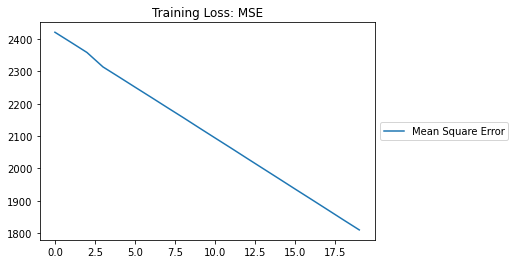

In [33]:
# Plot performance

from matplotlib import pyplot as plt

x = range(20)
plt.plot(x, simple.history['mse'], label="Mean Square Error")

plt.title("Training Loss: MSE")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()



# Predict External

count    250.000000
mean       3.257648
std        1.798860
min        0.000000
25%        2.050000
50%        2.527000
75%        3.755500
max       10.171000
Name: External, dtype: float64


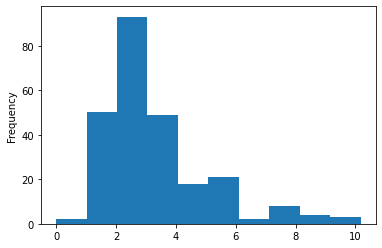

In [36]:
# Plot External Distribution

print(data.External.describe())

data.External.plot.hist()

In [37]:
# split data on external

x_train, x_test, y_train, y_test = split_data(matrix_indices, 'External')

print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(200, 324)
(50, 324)
(200, 1)
(50, 1)


In [40]:
# Build Model for External

model_external = Sequential()

model_internal.add(
    Embedding(
        input_dim = len(word2index),
        output_dim = 50,
        input_length = max_len_row,
        weights = [embedding_matrix],
        
    )
)

# Add a Simple RNN Layer
model_external.add(SimpleRNN(
    300,                    # Positive integer, dimensionality of the output space.
    return_sequences=True  # Boolean. Whether to return the last output in the output sequence, or the full sequence.
))

# Add a Dense Layer
model_external.add(Dense(
    1,                       # Positive integer, dimensionality of the output space.
    activation="relu"        # Activation function to use. If you don't specify anything, no activation is applied
))


model_external.compile(loss='mae',           # Loss function. Maybe be a string (name of loss function), or a tf.keras.losses.Loss instance.
              optimizer='adam',     # String (name of optimizer) or optimizer instance.
              metrics=['mse', 'mae'])      # List of metrics to be evaluated by the model during training and testing. 
model_external.summary()

ValueError: "input_length" is 324, but received input has shape (None, 324, 1, 50)

In [41]:
# Fit Model to Endorsements predictions

simple_external = model.fit(
    x_train, 
    y_train, # Endorsements
    batch_size=8, 
    epochs=20,
    validation_data=(
        x_test, 
        y_test # Endorsements
    )
)

Train on 200 samples, validate on 50 samples
Epoch 1/20
200/200 [==============================] - 5s 24ms/step - loss: 1592.8203 - mse: 1592.8203 - val_loss: 1689.6213 - val_mse: 1689.6215
Epoch 2/20
200/200 [==============================] - 5s 24ms/step - loss: 1564.4730 - mse: 1564.4728 - val_loss: 1659.9374 - val_mse: 1659.9374
Epoch 3/20
200/200 [==============================] - 5s 23ms/step - loss: 1536.4126 - mse: 1536.4125 - val_loss: 1630.8581 - val_mse: 1630.8582
Epoch 4/20
200/200 [==============================] - 5s 24ms/step - loss: 1508.7956 - mse: 1508.7954 - val_loss: 1601.3966 - val_mse: 1601.3966
Epoch 5/20
200/200 [==============================] - 5s 24ms/step - loss: 1481.1160 - mse: 1481.1160 - val_loss: 1572.0084 - val_mse: 1572.0084
Epoch 6/20
200/200 [==============================] - 5s 23ms/step - loss: 1453.6492 - mse: 1453.6492 - val_loss: 1542.4231 - val_mse: 1542.4231
Epoch 7/20
200/200 [==============================] - 5s 23ms/step - loss: 1426.2469 

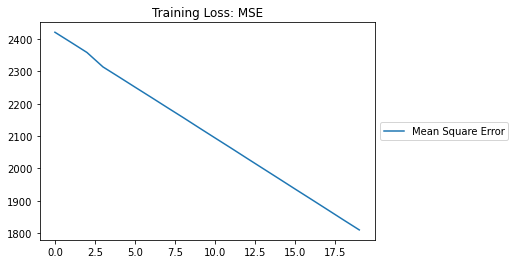

In [42]:
# Plot performance

from matplotlib import pyplot as plt

x = range(20)
plt.plot(x, simple.history['mse'], label="Mean Square Error")

plt.title("Training Loss: MSE")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()